# Lecture 27 - Solving First-Order IVPs Numerically

## Overview, Objectives, and Key Terms
 
The basics of ODEs were reviewed in [Lecture 26](ME400_Lecture_26.ipynb). There, SymPy was used to provide general solutions via `dsolve`, leaving application of initial and boundary conditions to the user.  However, SymPy (and other symbolic tools) cannot solve all differential equations.  For such equations, we can apply numerical techniques.  Specifically, we'll apply the finite-difference approximations presented in [Lecture 19](ME400_Lecture_19.ipynb).  For now, we'll consider only single, first-order equations, leaving systems for [Lecture 28](ME400_Lecture_28.ipynb).


### Objectives

By the end of this lesson, you should be able to

- Solve first-order IVPs numerically using forward and backward Euler's method
- Explain what is mean by local and global errors
- Explain what is meant by stability and how to achieve it

### Prerequisites

You should already be able to

- Solve ODEs based on what you've learned in a course like MATH 340 and [Lecture 26](ME400_Lecture_26.ipynb)
- Compute a first-order, finite-difference approximation for $\frac{df}{dx}$

### Key Terms


## There Once was a Man Named Euler

[Leonhard Euler](https://en.wikipedia.org/wiki/Leonhard_Euler) was a prolific mathematician, perhaps second only to [Carl Gauss](https://en.wikipedia.org/wiki/Carl_Friedrich_Gauss).  I point him out because the simplest (and probably best known) approach for solving $y' + py = q$ has his name.  (Point of trivia: he's buried in St. Petersburg, I was quite surprised to learn while strolling through an old cemetery).

The method bearing his name requires the [Numerical Differentiation](../../../courses/pythonic_apps_1/module_4/numerical_differentiation.rst) we learned previously.  Specifically, we need one of the first-order, finite-difference approximations for $dy/dt$.  You'll recall those are the *forward difference*
\begin{equation}
    \frac{dy}{dt} \approx \frac{y(t+\Delta)-y(t)}{\Delta} \, ,
\end{equation}
and the *backward difference*
\begin{equation}
    \frac{dy}{dt} \approx \frac{y(t)-y(t-\Delta)}{\Delta} \, .
\end{equation}

If we substitute the forward difference into the IVP, we find
\begin{equation}
    \frac{y(t+\Delta)-y(t)}{\Delta} + p(t)y(t) = q(t) + \mathcal{O}(\Delta^2) \, ,
\end{equation}
and by collecting the terms with $y(t)$ on the left, we have
\begin{equation}
    y(t+\Delta) = [1 - \Delta p(t)]y(t)  + \Delta q(t)  + \mathcal{O}(\Delta)  \, .
\end{equation}
Recognize that $y$ is now evaluated at the points $t_0, t_0+\Delta, t_0+2\Delta, \ldots$, or
\begin{equation}
    t_n = t_0 + n\Delta, \qquad n = 0, 1, 2, \ldots
\end{equation}

We could allow for a $\Delta$ that changes, but we'll keep it fixed for simplicity and leave the fancy stuff to SciPy.  Furthermore, let $y(t_{n})$ be written as $y_n$. Then, we can rewrite our *finite-difference* equation as
\begin{equation}
    y_{n+1} = [1 - \Delta p_n]y_n  + \Delta q_n \, ,
\end{equation}
which is the *forward Euler method*.  Use of the backward difference leads to the *backward Euler method*, which will come up next time in the context of *stability* of time-integration schemes for IVP's.  For both methods, the $\mathcal{O}(\Delta^2)$ error in the derivative leads to a a *local error* of $\mathcal{O}(\Delta)$ in the solution.

How high should $n$ go?  It depends on how long into the future (taking $t$ to represent time) we wish to evaluate the solution.  Let that future time be denoted $T$, and let the number of steps we wish to take be denoted $N$.  Consequently, $\Delta = (T-t_0)/N$.  We'll always start at $t=0$, so $\Delta = T/N$.

Let's illustrate by solving
\begin{equation}
    \frac{dy}{dt} + y(t) = 10, \qquad y(0) = 0, \qquad t \in [0, 10] \, .
\end{equation}
using $N=25$ points.

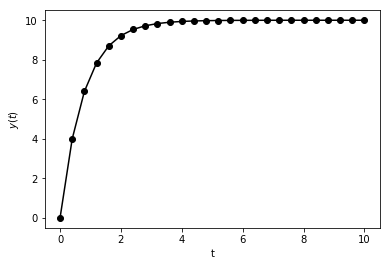

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

t_max = 10.0
N = 25

# Initialize the unknown (where "fe25" denotes Forward Euler with 15 points)
y_fe25 = np.zeros(N+1)

# Define the times and right-hand side.  We use N+1 
# because we want N points beyond the initial value.
t_fe25 = np.linspace(0, t_max, N+1)
q = 10*np.ones(N+1)
Delta = t_fe25[1]-t_fe25[0]

# Compute all successive values
for i in range(1, N+1) :
    y_fe25[i] = (1.0 - Delta)*y_fe25[i-1] + Delta*q[i-1]
    
plt.plot(t_fe25, y_fe25, 'k-o')
plt.xlabel('t')
plt.ylabel('$y(t)$')
plt.show()

Is this reasonable?  You should *always* do any "sanity" check available.  Here, the solution looks like it levels off, which suggests for long times, a *steady state* is reached.  Steady state means no change with time, and no change with time means $dy/dt = 0$.  

So what happens if we set $dy/dt=0$ in our IVP?  We find that $y(t) = 10$.  That seems consistent with the numerical result, but is it correct?  This problem is easy to solve directly, but we'll have SymPy produce an analytic result that be evaluated numerically later on:

In [2]:
import sympy as sy
sy.init_printing()
y_sy, t_sy = sy.symbols('y t') # use y_sy, t_sy to avoid overwriting other names
sol = sy.dsolve(sy.diff(y_sy(t_sy), t_sy) + y_sy(t_sy)-10, y_sy(t_sy)).rhs
y_exact_sy = sol.subs(sy.Symbol('C1'), sy.solve(sol.subs(t_sy, 0), sy.Symbol('C1'))[0])
y_exact_sy

That certainly goes to 10 as $t \to \infty$.  Let's visualize the numerical and analytical solutions:

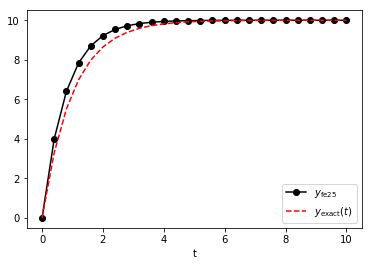

In [3]:
y_exact = sy.lambdify(t_sy, y_exact_sy)
plt.plot(t_fe25, y_fe25, 'k-o', t_fe25, y_exact(t_fe25), 'r--')
plt.xlabel('t')
plt.legend(['$y_{\\mathrm{fe25}}$', '$y_{\\mathrm{exact}}(t)$'], loc=0)
plt.show()

That's pretty close, but can we do better?  Let's try $N=100$:

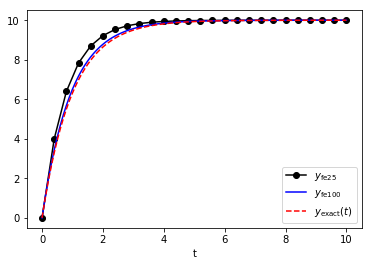

In [4]:
N = 100

# Initialize the unknown (where "fe25" denotes Forward Euler with 15 points)
y_fe100 = np.zeros(N+1)

# Define the times and right-hand side.  We use N+1 
# because we want N points beyond the initial value.
t_fe100 = np.linspace(0, t_max, N+1)
q = 10*np.ones(N+1)
Delta = t_fe100[1]-t_fe100[0]

# Compute all successive values
for i in range(1, N+1) :
    y_fe100[i] = (1.0 - Delta)*y_fe100[i-1] + Delta*q[i-1]

plt.plot(t_fe25, y_fe25, 'k-o', t_fe100, y_fe100, 'b', t_fe100, y_exact(t_fe100), 'r--')
plt.xlabel('t')
plt.legend(['$y_{\\mathrm{fe25}}$', '$y_{\\mathrm{fe100}}$', '$y_{\\mathrm{exact}}(t)$'], loc=0)
plt.show()

***

**Exercise**:  Finish the following function definition:

```python

def forward_euler(N, T, y0, p, q) :
    """Solves y' + py = q using forward Euler and a fixed time step.
    
       Inputs:
         N  - number of points (int)
         T  - final time (float)
         y0 - initial value of y (float)
         p  - coefficient value (float)
         q  - coefficient value (float)
         
       Returns:
         y  - values of y at each time step (NumPy array)
         t  - times at which y is evaluated (NumPy array)
    """

    return y, t
```

***

**Exercise**:  Repeat the last exercise but allow `p` and `q` to be callable functions of `t`.

***

**Exercise**: Implement backward Euler following the exercise above.

***

**Exercise**:  Apply forward Euler *by hand* to the following IVPs to approximate $y(1)$ using a step size $\Delta = 0.2$:
  1. $y' = y$ for $y(0) = 1$
  2. $y' = 2ty$ for $y(0) = 1$
  3. $y' = -y/10 + 1$ for $y(0) = 0$.

***

**Exercise**: Repeat the previous exercise but use backward Euler.

***

***

**Exercise**:  Consider the IVP $y' = f(t, y(t))$ subject to $y(0) = y_0$.  Here, $f(t, y(t))$ can be any function of $t$ or $y(t)$.  Examples include $f(t, y(t)) = ay + bt$ and $f(t, y(t)) = a y(t)^2$.  The latter case leads to a *nonlinear* IVP.  Given the initial condition, write down how you would determine $y(\Delta)$ using (a) forward Euler and (b) backward Euler.

***

**Exercise**:  Consider the following twist on Euler's method for $\frac{dy}{dt} = f(t)$ using fixed time steps $\Delta$:

$$
  \tilde{y}_{n+1} = y_n + \Delta f(t_n)
$$

and

$$
  y_{n+1} = y_n + \frac{\Delta}{2} [f(t_n) + \tilde{f}(t_{n+1})] \, .
$$

This is an example of a [multi-step method](https://en.wikipedia.org/wiki/Linear_multistep_method) and belongs to the famous [Runge-Kutta](http://mathworld.wolfram.com/Runge-KuttaMethod.html) family of methods.  This particular version is sometimes called [Heun's method](https://en.wikipedia.org/wiki/Heun%27s_method). 

Your task is to write a function `heun_method(N, T, y0, p, q)`.

***

## A Look at Errors and Stability

Certainly, the $N=100$ approximation looks better than the $N=25$ approximation. We can plot the errors for both as a function of time:

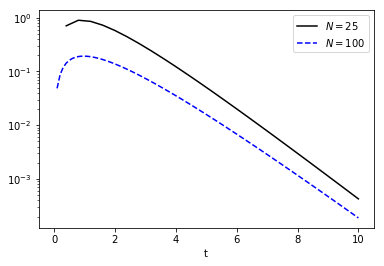

In [5]:
error_fe25 = y_fe25 - y_exact(t_fe25)
error_fe100 = y_fe100 - y_exact(t_fe100)
plt.semilogy(t_fe25, error_fe25, 'k-', t_fe100, error_fe100, 'b--')
plt.xlabel('t')
plt.legend(['$N=25$', '$N=100$'], loc=0, numpoints=1)
plt.show()

Clearly, the error for $N=25$ is larger over the time domain, as we might expect.  Recall that 
$(y_{n+1}-y_n)/\Delta = -py_n + q_n + \mathcal{O}(\Delta^2)$, so $y_{n+1} = (1-\Delta p)y_n + \Delta q_n + \mathcal{O}(\Delta)$.  This first-order error in $y_n$ is the *local error*, i.e., the error introduced by a single step in time.  On the other hand, the *global error* is the error shown above as a function of time.  A key question is how that global error at a fixed point in time depends on $\Delta$.  It turns out that if a method is *stable*, then the global error is of the same order as the local error.  

We'll skip momentarily what it means to be stable for now, but we can attack the global error for our simple problem (with a bit of help from SymPy).  For constant $q$, $p$ and $\Delta$, the analytic solution is
\begin{equation}
    y_n = \frac{q}{p} (1 - e^{-p \Delta n})  \, ,
\end{equation}
while the forward-Euler solution is
\begin{equation}
    \begin{aligned}
     y_n  &= \Delta q \sum^{n-1}_{i=0} (1-\Delta p)^{i} \\
          &= \Delta q \frac{1 - (1-\Delta p)^{n-1}}{\Delta p } \\
          &= \frac{q}{p} [ 1 - (1-\Delta p)^{n-1} ] \, .
    \end{aligned}
\end{equation}

For fixed $t$ and $\Delta$, the number of steps is $n = t/\Delta$, and the global error is therefore
\begin{equation}
     e(t) = \frac{q}{p} [e^{-p t}-(1-\Delta p)^{\frac{t}{\Delta} - 1} ] \, .
\end{equation}
Note first that 
\begin{equation}
     \lim_{\Delta \to 0} (1-\Delta p)^{t/\Delta} = e^{-p t} \, ,
\end{equation}
so $e_n = (q/p)[e^{-pt}-e^{-p/t}/(1-\Delta p)] \to 0$ as $\Delta \to 0$.  However, for fixed $t$, how *fast* does that error decrease with $\Delta$?  And for fixed $\Delta$, how does the error change with time?  Let's expand the error about $\Delta = 0$:

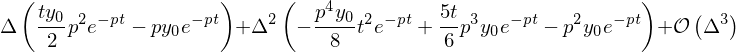

In [6]:
y0, Delta, n, p = sy.symbols('y0 Delta n p')
e = y0*(sy.exp(-p*t_sy)-(1-Delta*p)**(t_sy/Delta-1))
sy.series(e, Delta, 0, 3)

Evidently, the global error is of first order, consistent with the local error.  However, it's not clear (or easy to determine) exactly how the error depends on $t$ for fixed $\Delta$.  If we assume $p > 0$ (i.e., radioactive decay and not multiplying pythons), then 
\begin{equation}
    |e(t)| < \Big | q/ p \Big | \Big | (1-\Delta p)^{t/\Delta -1} \Big | \, .
\end{equation}
However, the right-hand side is bounded (i.e., does not grow with large $t$) only if $|1-\Delta p| < 1$, and that is true only if $\Delta < 2/p$.  To summarize: the global error does not blow up as long as $p > 0$ and $\Delta < 2/p$.

Of course, simply stating such rules is never as exciting as seeing what happens when the rules are broken, so we'll solve our example with $p = 2$, $q=10$, and $y(0) = 0$ for $N = 5$, $N = 10$, and $N = 20$:

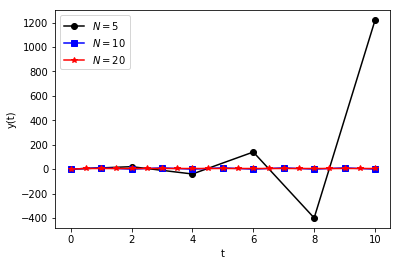

In [16]:
p = 2.0
q = 10.0
t = {}
y = {}
y0 = 0
for N in [5, 10, 20]:
    t[N] = np.linspace(0, 10, N+1)
    Delta = t[N][1]-t[N][0]
    y[N] = np.zeros(N+1)
    y[0] = y0
    for i in range(1, N+1):
        y[N][i] = (1.0 - Delta*p)*y[N][i-1] + Delta*q  #y[N][i-1] + Delta*(-p*y[N][i-1] + q)
    
plt.plot(t[5], y[5], 'k-o', t[10], y[10], 'b-s', t[20], y[20], 'r-*')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend(['$N=5$', '$N=10$',  '$N=20$'], loc=0)
plt.show()

Yikes! The $N=5$ case clearly does not converge to the steady-state value $y = 5$!  In other words, it *diverges*.  Because the forward-Euler approximation converges only for certain values of $\Delta$ and $p$, it is called a *conditionally stable* method.  

Conditional stability requires very small $\Delta$.  For problems whose solutions blow up (i.e., $p < 0$), all bets are off and an *unconditionally stable* method is the better choice. For example, the backward-Euler approximation is unconditionally stable, demonstration of which is an exercise left to the student.  

***

**Exercise**:  Repeat the example above (i.e., $p=2$, $q=10$, $y(0) = 0$, and $N = 5, 10, 20$) to show that backward Euler has no stability issues.

***

**Exercise**:  Use *backward Euler* to solve $y' = 2t - 3y + 1$ given $y(1) = 5$ and estimate $y(1.2)$.  Compare the error in this estimate for $\Delta = 0.1, 0.01, 0.001, 0.0001$.  How does this error depend on $\Delta$? 

***

**Exercise**:  Repeat the previous exercise using Heun's method (see previous exercise).

***

## IVP's with SciPy

SciPy includes a number of schemes for integration (e.g., the `scipy.integrate.quad` function we have previously used).  The `scipy.integrate` module also has routines for integrating IVP's.  To "integrate" a differential equation is to solve for the unknown function.

Specifically, the `scipy.integrate.odeint` function is used to solve individual, first-order IVP's or systems of such equations. We'll focus only on the former, leaving systems for next time.
Behind the scenes, either an [Adams](https://en.wikipedia.org/wiki/Linear_multistep_method#Adams.E2.80.93Moulton_methods) or [BDF](https://en.wikipedia.org/wiki/Backward_differentiation_formula) method is used depending on the behavior of the solution.  All of this is automatic, and more details can be found [in the documentation](http://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint). 

Let's revisit our example, namely $y' + y(t) = 10$ with $y(0)=0$ for $t\in [0, 10]$.  The `odeint` function requires, at a minimum, three inputs: (1) a function that evaluates the derivative $y'(t)$ given the time $t$ and the value of the function $f(t)$,  (2) the initial condition $y(0)=y_0$, and (3) the times at which $y(t)$ is to be evaluated.  These times are independent of the times and corresponding $\Delta$'s used internally; they only are used for the output.

The derivative function has two arguments: the time $t$ at which $y'$ is to be evaluated, and the value of $y$ at that same time.  That sounds like you need to know $y(t)$ beforehand---but you don't!  This derivative function is only called behind the scenes by `odeint` itself.  Hence, `odeint` knows (or has an approximation to) $y$ at the time $t$, and your job is to use the two to define $y'$.  For our example, that means we need a function that evaluates and returns
\begin{equation}
    \frac{dy}{dt} = 10 - y(t) \, .
\end{equation}

With that, we can implement a complete `odeint` solution to our example:

In [ ]:
from scipy.integrate import odeint

# derivative function
def y_prime(y, t) :
    return 10.0 - y

# times at which y(t) is to be evaluated
t_odeint = np.linspace(0, 10)

# solve with odeint
y_odeint = odeint(y_prime, y0=0.0, t=t_odeint)

plt.plot(t_odeint, y_odeint, 'k', t_odeint, y_exact(t_odeint), 'ro')
plt.legend(['$y_{\\mathrm{odeint}}$', '$y_{\\mathrm{exact}}$'], loc=0, numpoints = 1)
plt.show()

The `odeint` result is very good, with no discernible error (to my eyes, anyway).  We can plot the errors, but first we need to reshape the output from `odeint`.  Notice that it has an explicit, 2-D shape, whereas `y_exact` yields a 1-D array (from the 1-D `t_odeint`):

In [ ]:
print(y_odeint.shape)
print(y_exact(t_odeint).shape)
print(t_odeint.shape)

Normally, this apparent mismatch is no big deal---we plotted both against the same `t_odeint` array.  However, the mismatch does lead to strange results when we try to compute the error:

In [ ]:
error = y_odeint-y_exact(t_odeint)
print(error.shape)

That's not right---can you figure out why that is happening?  The solution, however, is to make them the same size, and we can do that, e.g., with an explicit reshaping:

In [ ]:
y_odeint_reshaped = y_odeint.reshape((len(t_odeint),))
error = y_odeint_reshaped - y_exact(t_odeint)
print(error.shape)

In [ ]:
plt.plot(t_odeint, error, 'r-o')
plt.xlabel('t')
plt.ylabel('$y_{\\mathrm{odeint}}-y_{\\mathrm{exact}}$')
plt.show()

Two features of this error warrant discussion.  First, the overall magnitude is small than the errors we found using $N=100$ above with forward Euler.  Second, the error fluctuates more than we found for forward Euler and is more uniform in magnitude.  The overall magnitude of the error is determined by the desired numerical accuracy (defined by the optional arguments `rtol` and `atol`).  The time-dependent fluctuations are due to use of nonuniform time steps.  The details are well beyond our scope, but you'll recall from the Taylor expansion of $y'$ that the errors are related to $y''$.  If some estimate can be made of $y''$ during the time-stepping procedure, then the error can also be estimated. Proper selection of $\Delta$ (either larger or smaller) can yield errors just within the desired tolerance, ensuring proper accuracy and avoiding use of too many small steps in regions where they are not needed.

***

**Exercise**: Solve the following IVPs using `odeint` and plot the result for $t \in [0, 5]$:

  1. $\frac{dy}{dt} = e^{-y}$ for $y(0) = 0$. 
  2. $\frac{dy}{dt} = x^2 + y^2$ for $y(0) = 1$. 
  3. $\frac{dy}{dt} = y - y^2$ for $y(0) = 0.5$.

***

## Further Reading

See the SciPy documentation on [odeint](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html#ordinary-differential-equations-odeint).  This will also be useful for the next lesson in which systems of IVP's (and higher-order IVP's) are solved.  Bennett's chapter on [population growth](https://www.math.ksu.edu/math240/book/chap1/pop.php) provides a bit more on first-order systems and their use in modeling populations.